# Logistic Regression

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import os
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import sklearn as skl

os.environ["CUDA_VISIBLE_DEVICES"]= "-1" # Force Tensorflow on CPU instead of GPU (seems to avoid an error with my CUDA compatible GPU)

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Data

In [2]:
# Load training data form NPZ file

train_data = "train.npz"
X_tr = np.load(train_data)["features"]
y_tr = np.load(train_data)["labels"]
images_tr = np.load(train_data)["pixels"]
names_tr = np.load(train_data)["names"]

valid_data = "valid.npz"
X_val= np.load(valid_data)["features"]
y_val = np.load(valid_data)["labels"]
images_val = np.load(valid_data)["pixels"]
names_val = np.load(valid_data)["names"]

test_data = "test.npz"
X_te= np.load(test_data)["features"]
y_te = np.load(test_data)["labels"]
images_te = np.load(test_data)["pixels"]
names_te = np.load(test_data)["names"]

# Create a dictionnary for labels
labels_dict = {0: 'bike', 1 : 'car', 2: 'motorcycle', 3: 'other', 4:'truck', 5: 'van'}

In [3]:
### Let's use a bigger dataset for training.

X = np.concatenate((X_tr,X_val), axis=0, out=None)  # X for Cross Validation and Grid Search
y = np.concatenate((y_tr,y_val), axis=0, out=None) 

In [4]:
X.shape 

(419, 2048)

# Create a pipeline for the Logistic Regression
Let's try with a low C =1e-5

In [5]:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logreg_pipe = Pipeline([
    ('scaler', StandardScaler()), # With standardization works better here
    ('logreg', LogisticRegression(solver='saga', C=1e-5, multi_class= 'multinomial'))
])



In [6]:
logreg_pipe.fit(X, y)

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

In [7]:
# Accuracy on test set
accuracy = logreg_pipe.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.680


# Cross Validation, Grid Search and tuning hyperparameters

I use GridSearchCV to be able to use preprocessing (Standard Scaler)

In [8]:
from sklearn.model_selection import GridSearchCV

grid_params = {'logreg__solver' : ['saga'],
               'logreg__multi_class' : ['ovr','multinomial'],
               'logreg__C' : np.logspace(-6, 4, num=11)}

In [9]:
# Types of scoring ==> could be useful to measure the mean squared error instead of accuracy (indeed we only have 50 images, so the accuracy jumps "2%" at each error)
skl.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [10]:
gs = GridSearchCV(logreg_pipe, grid_params, verbose = -1, cv = 6, n_jobs = 4, scoring='accuracy', refit = True, iid = True, return_train_score=True) # use 4 cores

In [11]:
gs_results = gs.fit(X, y)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 132 out of 132 | elapsed:  2.6min finished
C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [12]:
print('Best Params :',gs_results.best_params_)
print('Best Score :',gs_results.best_score_)

Best Params : {'logreg__C': 100.0, 'logreg__multi_class': 'multinomial', 'logreg__solver': 'saga'}
Best Score : 0.9427207637231504


In [13]:
# Calculate accuracy with the best estimator of the GridSearch Cross Validation
best_estimator = gs_results.best_estimator_
best_estimator.score(X_te,y_te)

0.96

In [14]:
gs_results.score

<bound method BaseSearchCV.score of GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'logreg__solver': ['saga'], 'logreg__multi_class': ['ovr', 'multinomial'], 'logreg__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=-1)>

# Plot 10 images and for each one, print the predicted probability.

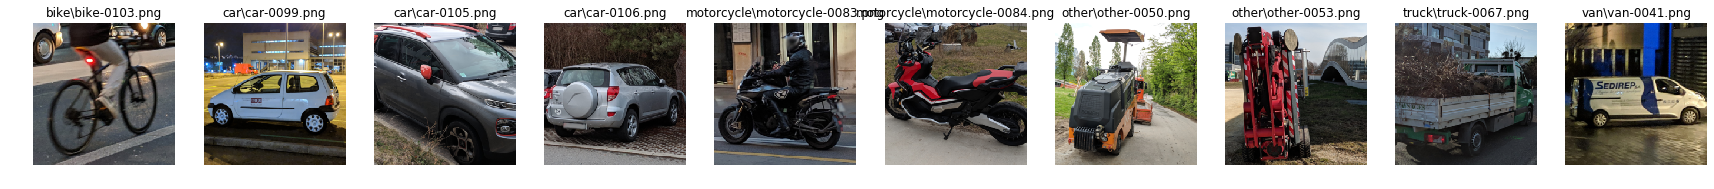

In [15]:
# Imshow random images in the test set with the filenames :

fig, ax = plt.subplots(1, 10, figsize =(30,5))

# Plot 10 images with pyplot

ax[0].imshow(images_te[3])
ax[0].set_title(names_te[3])
ax[0].axis('off')

ax[1].imshow(images_te[14])
ax[1].set_title(names_te[14])
ax[1].axis('off')

ax[2].imshow(images_te[20])
ax[2].set_title(names_te[20])
ax[2].axis('off')

ax[3].imshow(images_te[21])
ax[3].set_title(names_te[21])
ax[3].axis('off')

ax[4].imshow(images_te[29])
ax[4].set_title(names_te[29])
ax[4].axis('off')

ax[5].imshow(images_te[30])
ax[5].set_title(names_te[30])
ax[5].axis('off')

ax[6].imshow(images_te[33])
ax[6].set_title(names_te[33])
ax[6].axis('off')

ax[7].imshow(images_te[36])
ax[7].set_title(names_te[36])
ax[7].axis('off')


ax[8].imshow(images_te[41])
ax[8].set_title(names_te[41])
ax[8].axis('off')

ax[9].imshow(images_te[48])
ax[9].set_title(names_te[48])
ax[9].axis('off')

plt.show()

In [16]:
# Print predictions of the image
list_images = [3,14,20,21,29,30,33,36,41,48]
list_prediction = []

for i in list_images:
    prediction = list(best_estimator.predict_proba(X_te)[i])
    prediction.insert(0,names_te[i]) # include name of the file in first element of the list
    list_prediction.append(list(prediction))
    
# Create a dataframe   
proba_df = pd.DataFrame(list_prediction, columns = ['filename','bike','car','motorcycle','other','truck','van'])
proba_df=proba_df.set_index('filename')
proba_df = proba_df.round(2)
proba_df

,bike,car,motorcycle,other,truck,van
filename,,,,,,
bike\bike-0103.png,1.0,0.00,0.0,0.0,0.00,0.00
car\car-0099.png,0.0,0.98,0.0,0.0,0.00,0.02
car\car-0105.png,0.0,1.00,0.0,0.0,0.00,0.00
car\car-0106.png,0.0,0.99,0.0,0.0,0.00,0.01
motorcycle\motorcycle-0083.png,0.0,0.00,1.0,0.0,0.00,0.00
motorcycle\motorcycle-0084.png,0.0,0.00,1.0,0.0,0.00,0.00
other\other-0050.png,0.0,0.00,0.0,0.1,0.90,0.00
other\other-0053.png,0.0,0.00,0.0,1.0,0.00,0.00
truck\truck-0067.png,0.0,0.00,0.0,0.0,1.00,0.00


We notice that the picture other-0050 is not well predicted, and indeed, even I, as a human, struggle to understand what kind of vehicle it is.
The rest of them have really strong "good" prediction. (close to 1)


### Let's make the predictions probability for different C values (same values as GridSearch)


In [17]:
list_prediction2 = []
list_images2 = [3,14,20,21,29,30,33,36,41,48]
c_val_list = np.logspace(-6, 6, num=13)

for c_val in c_val_list :
    
    logreg_pipe_2 = Pipeline([
    ('scaler', StandardScaler()), # With standardization works better here
    ('logreg', LogisticRegression(solver='saga', C=c_val, multi_class= 'multinomial'))])
    
    logreg_pipe_2.fit(X, y)
    
    for i in list_images2:
        prediction2 = list(logreg_pipe_2.predict_proba(X_te)[i])
        prediction2.insert(0,c_val) # include C value
        prediction2.insert(0,names_te[i]) # include name of the file in first element of the list
        list_prediction2.append(list(prediction2))

# Create a dataframe   
proba_df2 = pd.DataFrame(list_prediction2, columns = ['filename','C values','bike','car','motorcycle','other','truck','van'])
# proba_df2 = proba_df2.set_index('filename')
# proba_df2 = proba_df2.round(2)
proba_df2.head(10)

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\sag.py:334: Convergence

,filename,C values,bike,car,motorcycle,other,truck,van
0,bike\bike-0103.png,0.000001,0.208766,0.193067,0.170095,0.141629,0.155568,0.130876
1,car\car-0099.png,0.000001,0.194794,0.204007,0.168000,0.142264,0.157141,0.133793
2,car\car-0105.png,0.000001,0.195755,0.205313,0.168347,0.141879,0.155966,0.132740
3,car\car-0106.png,0.000001,0.194135,0.206642,0.167290,0.142605,0.156314,0.133015
4,motorcycle\motorcycle-0083.png,0.000001,0.200408,0.191343,0.180982,0.141287,0.155197,0.130783
5,motorcycle\motorcycle-0084.png,0.000001,0.197114,0.190247,0.182291,0.142306,0.156621,0.131420
6,other\other-0050.png,0.000001,0.195370,0.194781,0.169456,0.145557,0.161732,0.133103
7,other\other-0053.png,0.000001,0.198062,0.195209,0.169433,0.146731,0.158572,0.131994
8,truck\truck-0067.png,0.000001,0.194134,0.197272,0.169387,0.144184,0.161509,0.133514
9,van\van-0041.png,0.000001,0.195371,0.197205,0.169650,0.142743,0.160372,0.134660


In [18]:
list(set(proba_df2['filename']))

['car\\car-0105.png',
 'car\\car-0106.png',
 'other\\other-0053.png',
 'car\\car-0099.png',
 'motorcycle\\motorcycle-0084.png',
 'motorcycle\\motorcycle-0083.png',
 'bike\\bike-0103.png',
 'van\\van-0041.png',
 'other\\other-0050.png',
 'truck\\truck-0067.png']

### We have a dataframe of shape 110 (10 images x 11 C values) x 7 columns (6 types + 1 C value)

Let's show the different probabilities for one image and each C value

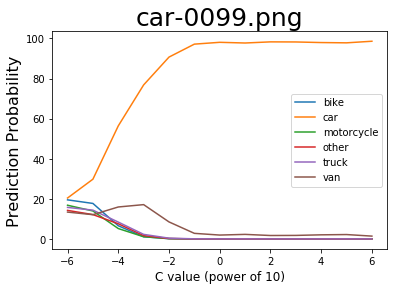

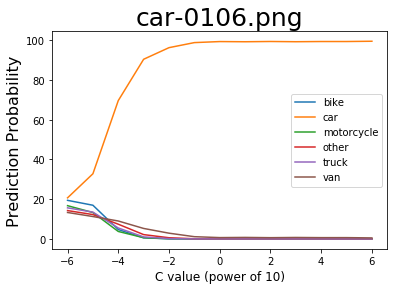

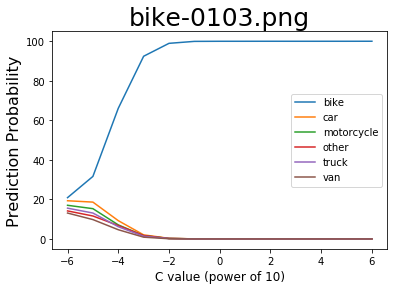

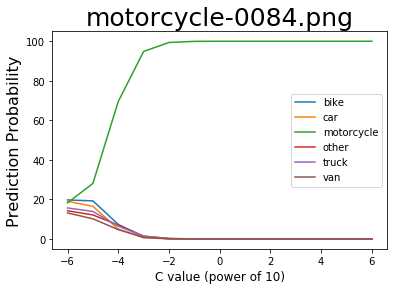

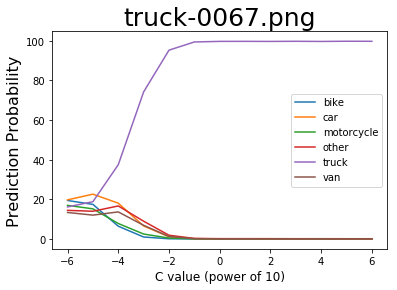

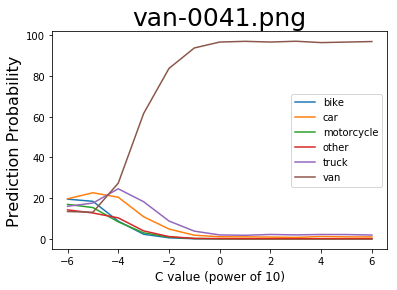

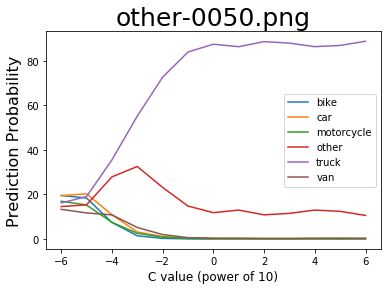

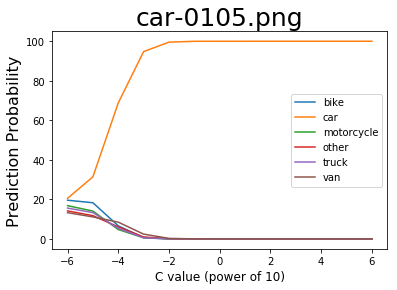

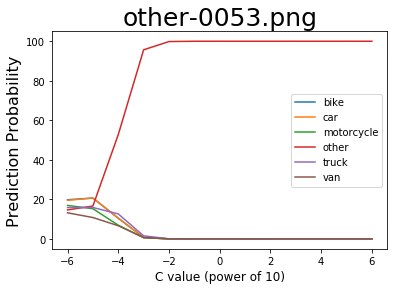

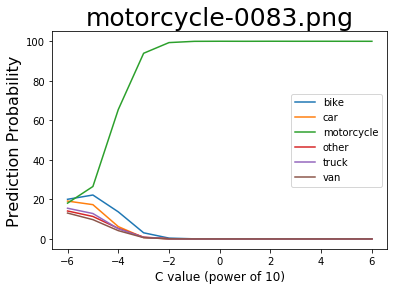

In [19]:
list_chosen_images = ['car-0099.png',
 'car-0106.png',
 'bike-0103.png',
 'motorcycle-0084.png',
 'truck-0067.png',
 'van-0041.png',
 'other-0050.png',
 'car-0105.png',
 'other-0053.png',
 'motorcycle-0083.png'] # without the '\' antislash which brings an error : "bad escape \c at position"

for image_name in list_chosen_images:
    
    C_log = np.log10(proba_df2.loc[proba_df2['filename'].str.contains(image_name)]['C values']) # show logarthmic values for C
    
    # Each probability for the chosen image
    p_bike = proba_df2.loc[proba_df2['filename'].str.contains(image_name)]['bike']
    p_car = proba_df2.loc[proba_df2['filename'].str.contains(image_name)]['car']
    p_motor = proba_df2.loc[proba_df2['filename'].str.contains(image_name)]['motorcycle']
    p_oth = proba_df2.loc[proba_df2['filename'].str.contains(image_name)]['other']
    p_trk = proba_df2.loc[proba_df2['filename'].str.contains(image_name)]['truck']
    p_van = proba_df2.loc[proba_df2['filename'].str.contains(image_name)]['van']
    
    plt.plot(C_log,p_bike*100)
    plt.plot(C_log,p_car*100)
    plt.plot(C_log,p_motor*100)
    plt.plot(C_log,p_oth*100)
    plt.plot(C_log,p_trk*100)
    plt.plot(C_log,p_van*100)
    
    plt.xlabel('C value (power of 10)', fontsize=12)
    plt.ylabel('Prediction Probability', fontsize=16)
    plt.legend()
    plt.title(image_name,  fontsize= 25)
    plt.show()



### From what I understand here, I am pleased to notice that indeed, the higher the C, the better is the prediction (same as the best_estimator_ from GridSearchCV : C = 10000)

For a low C around ~ 1e-6 to 1e-4, the loss is strongly diminished by the C, so the prediction is close to the baseline : 1/6 probability (~17%).

When the C reaches around 1e-2, the "right" prediction seems to reach almost 95% everytime (except for Other-0050).

**After this value (C > 1e-2), the prediction does not converge to much better results with higher C values.**

> Note It is interesting to note also for this "Other-0050" picture, even I, as a human, struggle to notice what kind of vehicule it is exactly. Some kind of contruction vehicle that I don't know.

# So far, Logistic Regression has the best results on the test Set : 48/50.

# Save results

In [20]:
import csv

header = ['model', 'test_accuracy']
data = ['Logistic Regression',best_estimator.score(X_te,y_te)]


with open('Results.csv', 'a', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)


    # write the data
    writer.writerow(data)